# Image Segmentation with custom U-Net Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_unet_segmentation_tf.ipynb)

The U-Net Architecture will be consist of a Encoder/Contracting and Decoder/Expansive Model

![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## Basic Flow
1. Download and Load the training and valdiation data
3. Create a CNN Model
4. Train the model
5. Test the model

## Step 1: Download and arrange dataset in file system

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteUE1RVX/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteUE1RVX/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


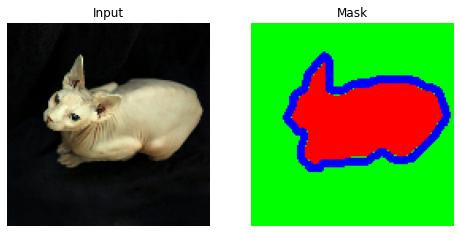

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds # we will be using dataset available from here   
import matplotlib.pyplot as plt   # For plotting graphs and showing images
from IPython.display import clear_output  # for clearing the console output
import numpy as np

# Reduce precission and speed thing up 60% on TPU and 3x on Modern GPU - optional
tf.keras.mixed_precision.set_global_policy('mixed_float16')

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
num_classes = 3

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.0
  mask -= 1 # mask values {1,2,3} to {0,1,2}
  mask = tf.cast(mask, tf.int32)
  mask = tf.squeeze(mask)
  mask = tf.one_hot(mask, num_classes)
  mask = tf.cast(mask, tf.float32)
  return image, mask

@tf.function
def load_image(datapoint):
  image = tf.image.resize(datapoint['image'], (IMG_WIDTH,IMG_HEIGHT))
  mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_WIDTH,IMG_HEIGHT))
  image, mask = normalize(image, mask)
  return image, mask

train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train.batch(BATCH_SIZE).cache()
val_ds = val.batch(BATCH_SIZE)

def display(ds_list):
  plt.figure(figsize=(8,8))
  title = ['Input', 'Mask', 'Prediction']

  for i in range(len(ds_list)):
    plt.subplot(1,len(ds_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ds_list[i]))
    plt.axis('off')
  
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Step 2: Create the Model 

In [3]:
def create_model():
  inputs = layers.Input(((IMG_WIDTH,IMG_HEIGHT, IMG_CHANNELS)))
  UNet_steps = 4 # default = 4
  filter_size = 32 # default = 16 
  encoded_layers = []
  p = inputs
  # Contraction Path - The Start and fall of U
  for i in range(UNet_steps):
    c = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(p)
    c = layers.Dropout(0.2)(c)
    c = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(c)
    p = layers.MaxPool2D()(c)
    encoded_layers.append(c)
    # filter size is doubled every step
    filter_size *= 2

  # The Bottom - The bottom of U
  # Block Rock Bottom
  cf = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(p)
  cf = layers.Dropout(0.2)(cf)
  cf = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(cf)

  cm = cf
  # Expanding Path - The Middle and rise of U
  for i in range(UNet_steps):
    # filter size is halved every step
    filter_size /= 2
    um = layers.Conv2DTranspose(filter_size, (2,2), strides=(2,2), activation='relu', padding='same')(cm)
    c = encoded_layers.pop()
    um = layers.concatenate([um, c])
    cm = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(um)
    cm = layers.Dropout(0.2)(cm)
    cm = layers.Conv2D(filter_size, (3,3), activation='relu', padding='same')(cm)

  outputs = layers.Conv2D(num_classes,(1,1), activation='sigmoid')(cm)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

  return model

model = create_model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()
# tf.keras.utils.plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 9248        dropout_9[0][0]                  
____________________________________________________________________________________________

## Step 3: Train the Model

Epoch 1/100
115/115 [==============================] - 63s 203ms/step - loss: 0.9510 - accuracy: 0.5539 - val_loss: 0.7378 - val_accuracy: 0.6950
Epoch 2/100
115/115 [==============================] - 21s 179ms/step - loss: 0.7195 - accuracy: 0.7014 - val_loss: 0.6781 - val_accuracy: 0.7105
Epoch 3/100
115/115 [==============================] - 21s 182ms/step - loss: 0.6566 - accuracy: 0.7285 - val_loss: 0.6297 - val_accuracy: 0.7420
Epoch 4/100
115/115 [==============================] - 21s 179ms/step - loss: 0.6311 - accuracy: 0.7423 - val_loss: 0.5771 - val_accuracy: 0.7689
Epoch 5/100
115/115 [==============================] - 20s 179ms/step - loss: 0.5726 - accuracy: 0.7721 - val_loss: 0.5188 - val_accuracy: 0.7968
Epoch 6/100
115/115 [==============================] - 20s 178ms/step - loss: 0.5131 - accuracy: 0.7999 - val_loss: 0.4717 - val_accuracy: 0.8172
Epoch 7/100
115/115 [==============================] - 21s 180ms/step - loss: 0.4791 - accuracy: 0.8144 - val_loss: 0.4620 -

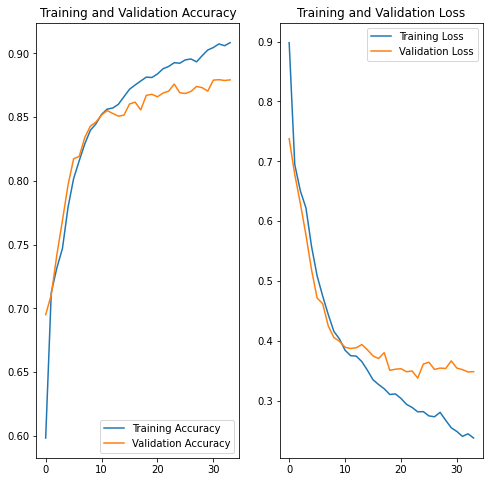

In [4]:
epochs = 100
# You also specify if there is no improvement in the accuracy/loss you can stop with a callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6) 

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs, 
                    callbacks=[early_stopping])

def plot_acc_loss(history, epochs_ran):
  # Lets plot the accuracy and loss over epochs
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs_ran)

  # below is matplotlib api's to plot line graph
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('H.png')

# Thats it at this point the model is trained
if (early_stopping.stopped_epoch == 0): 
  epochs_ran = epochs
else:
  epochs_ran = early_stopping.stopped_epoch+1 

plot_acc_loss(history, epochs_ran)

## Step 4: Play with some predictions results

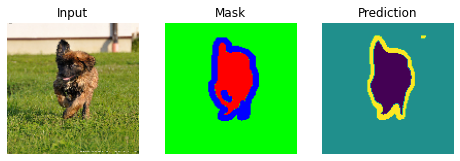

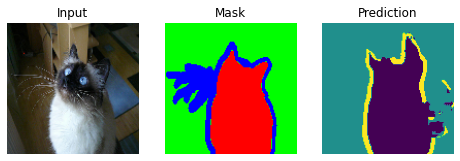

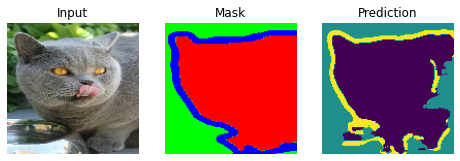

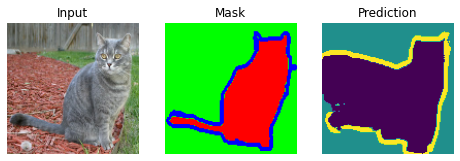

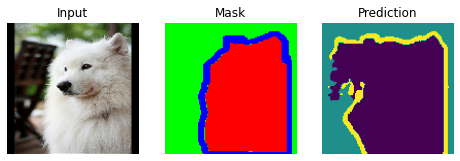

In [38]:
for image, mask in val_ds.take(5):
  predictions = model.predict(image)
  pred_mask = tf.argmax(predictions[0], axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  display([image[0], mask[0], pred_mask])

114688/110153 [===============================] - 0s 0us/step


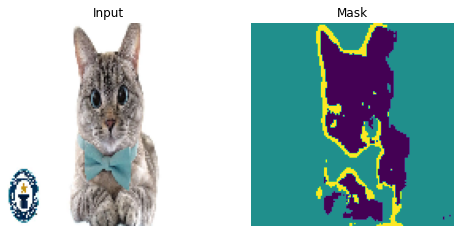

In [39]:
# Place an url of any new images and try the results 
image_url = "https://i.ytimg.com/vi/76Bm8W6W3Oo/maxresdefault.jpg"

# tf cahces the data to be dowloaded, so just make sure we clean if any previous image was already stored
!rm datasets/Image.png

# Download the image to local storage
image_path = tf.keras.utils.get_file('Image.png', origin=image_url, cache_dir="./")
# Load the image from local storage using tensorflow api's 

img = tf.keras.preprocessing.image.load_img(
    image_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT)
    )

img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

mask_p = np.argmax(predictions[0], axis=-1)
mask_p = np.expand_dims(mask_p, -1)

display([img, mask_p])